# Exploring _Cash for Clunkers_ Data

John Burnette - Thinkful Data Science 

### Explanation of the program, from [Wikipedia](https://en.wikipedia.org/wiki/Car_Allowance_Rebate_System)
The Car Allowance Rebate System (CARS), colloquially known as "cash for clunkers", was a 3 billion dollar U.S. federal scrappage program intended to provide economic incentives to U.S. residents to purchase a new, more fuel-efficient vehicle when trading in a less fuel-efficient vehicle. The program was promoted as providing stimulus to the economy by boosting auto sales, while putting safer, cleaner, and more fuel-efficient vehicles on the roadways.

### Eligibility criteria
- Vehicle must be less than 25 years old on the trade-in date.
- Only the purchase or 5 year minimum lease of new vehicles qualify.
- Generally, trade-in vehicles must get a weighted combined average rating of 18 or fewer miles per gallon (some very large pickup trucks and cargo vans have different requirements).
- Trade-in vehicles must be registered and insured continuously for the full year preceding the trade-in.
- Trade-in vehicles must be in driveable condition.
- The new car bought under the plan must have a suggested retail price of no more than 45,000 dollars, and for passenger automobiles, the new vehicle must have a combined fuel economy value of at least 22 mpg‑US (There were some allowances for high occupancy vehicles and trucks)

### Data sources
Data for this program, detailing both cars traded in and new cars purchased (or leased) are listed on www.data.gov Unfortunately, the links for those datasets are currently broken. They were retrieved using The Internet Wayback Machine with a 2013 scan date.

MPG data for either the trade-in cars or the purchased cars were not provided in the _Cash for Clunkers_ dataset. This information was obtained from [a separate database](https://www.fueleconomy.gov/feg/download.shtml). 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
trade_in = pd.DataFrame
trade_in = pd.read_csv('~/Desktop/trade-in-vehicles.csv')
new_vehicle = pd.DataFrame
new_vehicle = pd.read_csv('~/Desktop/new-vehicles.csv')

### Initial Reflections on _Cash for Clunkers_ Datasets
1. The Trade-In data is provided by with a "counts" column. 
2. The __Wayback__ method of getting the first two data sets did not include a data description. I'm not at all sure how the "Vehicle-Category" was defined. Clearly some of the vehicles listed as "Trucks" are not Trucks or even on a truck chassis. Examples from the New Vehicle data: Chevy Aveo, Cobalt, Impala, HHR are all listed as "Category 1 truck". Clearly something is messed up. Fortunately the MPG dataset includes a Category description as well. (See below.)
3. The New Vehicle data is separated first by make, then by YEAR, finally by Model.
4. Much data is missing, or at least non-standard.
5. Data is compiled by brand name, that is, GM is not individualized, but separated by Buick, Chevrolet, etc. Same with Ford/Mercury. I will be aggregating the data based on Parent company who owned each brand in 2009.

In [3]:
MPG_data = pd.DataFrame
MPG_data = pd.read_csv('~/Desktop/vehicles.csv')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (73,74,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Initial Reflections on _MPG_ Dataset
1. This dataset has a large number of unnecessary columns. 
2. This dataset seems have been compiled under the same authority as the Cash for Clunkers data, as model descriptions are identical in almost every instance.
3. There are a few models in given years which more than one MPG, thus I will need to take the mean of data found.
4. When aggregated by model in both trade-in and new-vehicle datasets the MPG will need to be taken with weighted averages (e.g. 10 Explorers 4WD at 14 mpg and 20 Explorers 2WD at 17 mpg will average to 16 mpg.
5. I will not be using data in columns 73, 74, or 76, so I can safely ignore the warning above.

## Exploration 1: 
Did the program obtain its goal of improving US fleet efficiency?

#### Step 1: 
I standardized Column Headers in both Trade_in and New_vehicle DataFrames.

In [4]:
col_dict = {"Trade_in_Vehicle_Category":"Category",
            "Trade_in_make": "Make",
            "Trade_in_Model":"Model",
            "Trade_in_Year":"Year",
            "Count":"Count"
           }

In [5]:
trade_in.columns = [col_dict.get(x,x) for x in trade_in.columns]

In [6]:
col_dict2 = {"New_Vehicle_Category":"Category",
            "New_Vehicle_Make": "Make",
            "New_Vehicle_Model":"Model",
            "New_Vehicle_Year":"Year",
            "Count":"Count"
           }

In [7]:
new_vehicle.columns = [col_dict2.get(x,x) for x in new_vehicle.columns]

#### Step 2: I trim the MPG dataset keeping only data I care about.

In [8]:
MPG_trimmed = pd.DataFrame
MPG_trimmed = MPG_data[['comb08','drive','fuelType','make','model','VClass','year']]

#### Step 3
I transfer the combined MPG data for each entry in both DataFrames, given the Model and Year

In [9]:
def MPG(myModel,myYear):
    return MPG_trimmed.loc[(MPG_trimmed['model'].str.lower()==myModel.lower()) &
                    (MPG_trimmed['year']==myYear)]['comb08'].mean()

The length of the DataFrame trade_in, is 8102, so I begin to capture MPG data

__Question__ Is this really the only way to do this?

In [10]:
for n in range(0, 8101):
    myModel = trade_in.loc[n,'Model']
    myYear = trade_in.loc[n,'Year']
    trade_in.loc[n,'MPG']=MPG(myModel,myYear)

The length of the DataFrame _new_vehicle_, is 1765. It's not that fewer cars were purchased than traded in, just that most models had multiple cars purchased.

In [12]:
for n in range(0, 1764):
    myModel = new_vehicle.loc[n,'Model']
    myYear = new_vehicle.loc[n,'Year']
    new_vehicle.loc[n,'MPG']=MPG(myModel,myYear)

#### Step 4
To get a quick and easy look at the results of the program, I'll remove any car which could not retrieve it's MPG in this first easy step. At first glance we can see that overall MPG improvement appears to have gone up by over 8 MPG.

In [15]:
new_vehicle_easy = new_vehicle.loc[np.isfinite(new_vehicle['MPG'])]

In [16]:
np.average(new_vehicle_easy['MPG'].tolist(),weights=new_vehicle_easy['Count'].tolist())

24.523241896544793

In [18]:
trade_in_easy = trade_in.loc[np.isfinite(trade_in['MPG'])]

In [19]:
np.average(trade_in_easy['MPG'].tolist(),weights=trade_in_easy['Count'].tolist())

16.174901905239096

#### First issue with Data
There were 411 entries in the turn_in DataFile where the model was given as "UNLISTED". In such cases I decided to take the average of ALL models made by that maker in that year.  <br><br>
There were 10 such data in the new_vehicle database.

In [20]:
def MPG_by_Make(myMake,myYear):
    return MPG_trimmed.loc[(MPG_trimmed['make'].str.lower()==myMake.lower()) &
                    (MPG_trimmed['year']==myYear)]['comb08'].mean()

In [21]:
for n in range(0, 8101):
    if (trade_in.loc[n,'Model']=="UNLISTED"):
        myMake = trade_in.loc[n,'Make']
        myYear = trade_in.loc[n,'Year']
        trade_in.loc[n,'MPG'] = MPG_by_Make(myMake,myYear)

In [22]:
for n in range(0, 1764):
    if (new_vehicle.loc[n,'Model']=="UNLISTED"):
        myMake = new_vehicle.loc[n,'Make']
        myYear = new_vehicle.loc[n,'Year']
        new_vehicle.loc[n,'MPG'] = MPG_by_Make(myMake,myYear)

In [23]:
trade_in.loc[np.isnan(trade_in['MPG'])]

,Category,Make,Model,Year,Count,MPG
3,1 - Category 1 Truck,ASC Incorporat,UNLISTED,1987,1,NaN
25,1 - Category 1 Truck,American Motor,UNLISTED,1985,1,NaN
26,1 - Category 1 Truck,American Motor,UNLISTED,1986,2,NaN
27,1 - Category 1 Truck,American Motor,UNLISTED,1987,6,NaN
49,1 - Category 1 Truck,BMW,325i,1992,4,NaN
118,1 - Category 1 Truck,Cadillac,DeVille,1993,5,NaN
173,1 - Category 1 Truck,Chevrolet,APV 2WD,1990,23,NaN
174,1 - Category 1 Truck,Chevrolet,APV 2WD,1991,16,NaN
175,1 - Category 1 Truck,Chevrolet,APV 2WD,1992,38,NaN
176,1 - Category 1 Truck,Chevrolet,APV 2WD,1993,28,NaN


In [26]:
new_vehicle.loc[np.isnan(new_vehicle['MPG'])]

,Category,Make,Model,Year,Count,MPG
27,1 - Category 1 Truck,BMW,X3 xDrive 30i,2009,126,NaN
79,1 - Category 1 Truck,Chevrolet,HHR Panel FWD,2010,7,NaN
114,1 - Category 1 Truck,Chrysler,Town and Country,2008,17,NaN
117,1 - Category 1 Truck,Chrysler,Town and Country/Voyager/Grand Voy,2008,31,NaN
133,1 - Category 1 Truck,Dodge,Journey 2WD,2009,2499,NaN
134,1 - Category 1 Truck,Dodge,Journey 2WD,2010,82,NaN
135,1 - Category 1 Truck,Dodge,Journey 4WD,2009,4,NaN
136,1 - Category 1 Truck,Dodge,Journey 4WD,2010,5,NaN
179,1 - Category 1 Truck,Ford,F150 Pickup FFV 2WD,2009,14,NaN
180,1 - Category 1 Truck,Ford,F150 Pickup FFV 2WD,2010,3,NaN


#### Next issue with Data
This gets us down to only 249 data points and now only 4 models as UNLISTED in the trade_in database.
The next thing to try is to see if we can get the model to be recognized by just the first word in the model. There is also an issue with a few models and case of letters so we'll also take care of that.

In [27]:
def MPG_by_Name_Split(myModel,myYear):
    return MPG_trimmed.loc[(MPG_trimmed['model'].str.startswith(myModel)) &
                           (MPG_trimmed['year']==myYear)]['comb08'].mean()

In [28]:
for n in range(0, 8101):
    if (np.isnan(trade_in.loc[n,'MPG'])):
        myModel = trade_in.loc[n,'Model'].split()[0]
        myYear = trade_in.loc[n,'Year']
        trade_in.loc[n,'MPG'] = MPG_by_Name_Split(myModel,myYear)

In [29]:
for n in range(0, 1764):
    if (np.isnan(new_vehicle.loc[n,'MPG'])):
        myModel = new_vehicle.loc[n,'Model'].split()[0]
        myYear = new_vehicle.loc[n,'Year']
        new_vehicle.loc[n,'MPG'] = MPG_by_Name_Split(myModel,myYear)

In [30]:
trade_in.loc[np.isnan(trade_in['MPG'])]

,Category,Make,Model,Year,Count,MPG
3,1 - Category 1 Truck,ASC Incorporat,UNLISTED,1987,1,NaN
25,1 - Category 1 Truck,American Motor,UNLISTED,1985,1,NaN
26,1 - Category 1 Truck,American Motor,UNLISTED,1986,2,NaN
27,1 - Category 1 Truck,American Motor,UNLISTED,1987,6,NaN
173,1 - Category 1 Truck,Chevrolet,APV 2WD,1990,23,NaN
174,1 - Category 1 Truck,Chevrolet,APV 2WD,1991,16,NaN
175,1 - Category 1 Truck,Chevrolet,APV 2WD,1992,38,NaN
176,1 - Category 1 Truck,Chevrolet,APV 2WD,1993,28,NaN
579,1 - Category 1 Truck,Chevrolet,Suburban V10 4WD,1987,5,NaN
747,1 - Category 1 Truck,Chrysler,Voyager,2002,51,NaN


In [31]:
new_vehicle.loc[np.isnan(new_vehicle['MPG'])]

,Category,Make,Model,Year,Count,MPG
1104,3 - Category 3 Truck,Mercedes-Be,UNLISTED,2008,1,NaN
1764,P - Passenger Car,smart,fortwo coupe,2009,913,NaN


#### From here, if it is important, we'll do things by hand.
We've resolved all but 77 data points and a glance at the remaining would be most quickly resolved by performing research on the model by hand.  For example the Chevrolet APV is Lumina Van.  Chevy refered to it as "APV" for only 3 years, but the name stuck. I'm assuming that the remaining data points _could_ similarly be resolved very quickly, much more quickly than attempting to continue to automate it. But for expediency I will just remove those 77 data points.

As far as the new_vehicle database goes, there were only two points left, a Mercedes "Category 3 truck" of UNLISTED model, which I'm assuming to be a Sprinter van. And a Smart car of model "fortwo coupe" which is important I get correct as 913 were sold in the program. The Smart car had combined MPG of 36 and the Sprinter van had a MPG of 25.2.  I assumed that the van had to be a diesel model as the gas model's MPG of 16 would not have qualified for the program. <br><br>
The _new-vehicle_ database has be ungraded at this point, the _trade-in_ database has not been (yet).

In [64]:
new_vehicle.loc[1764,'MPG']=36

In [33]:
new_vehicle.loc[1104,'MPG']=25.2

In [34]:
trade_in = trade_in[np.isfinite(trade_in['MPG'])]
trade_in.index = range(len(trade_in.index))

In [35]:
trade_in.loc[np.isnan(trade_in['MPG'])]

,Category,Make,Model,Year,Count,MPG


In [36]:
new_vehicle.loc[np.isnan(new_vehicle['MPG'])]

,Category,Make,Model,Year,Count,MPG


## Making Comparative Histograms 

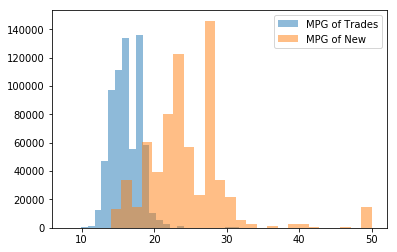

In [41]:
val, weight = trade_in['MPG'].tolist(),trade_in['Count'].tolist()
plt.hist(val, weights = weight, alpha=0.5, bins = 25, label='MPG of Trades')
valn, weightn = new_vehicle['MPG'].tolist(),new_vehicle['Count'].tolist()
plt.hist(valn, weights = weightn, alpha=0.5, bins = 25, label='MPG of New')
plt.legend(loc='upper right')
plt.show()

## Conclusion 1:
The graph above clearly showed that the program obtained one of it's major objectives: namely providing a large boost to the fleet efficiency of cars currently on the road in 2009.

## Exploration 2:
Which corporations benefitted the most from the program?

### Discussion:
1. While there is something to be said for dealer profits from maintaining older cars, this is a a minimal concern as most repairs of 10+ year old cars don't happen at a dealer nor do they typically use factory parts.  Thus I take it as an axiom that virtually all benefit to car companies flow from sales of new vehiclees. <br>
2. Because of inherent difference between the size of corporations, we must consider the percentage of sales through this program and that of nearby time periods without this program. Those with a marked diffference between their usual sales market and their "piece" of the Cash for Clunkers program can be considered as benefitting (or perhaps being harmed by) the program.
3. While it might be interesting to consider this question brand by brand, I am chosing to group by the largest corporation 

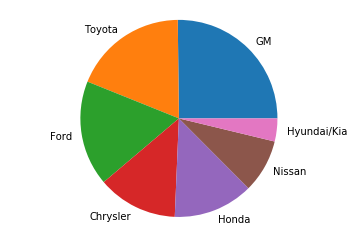

In [44]:
labels = 'GM', 'Toyota', 'Ford', 'Chrysler', 'Honda', 'Nissan', 'Hyundai/Kia'
sizes = [20.7, 15.4, 14.2, 10.8, 10.8, 7.2, 3.1]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels)
ax1.axis('equal')
plt.show()

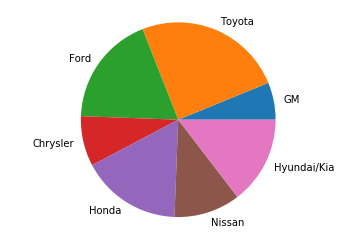

In [63]:
labels = 'GM', 'Toyota', 'Ford', 'Chrysler', 'Honda', 'Nissan', 'Hyundai/Kia'
sizes = [GM_Sales, Toyota_Sales, Ford_Sales, Chrysler_Sales, Honda_Sales, Nissan_Sales, Kia_Sales]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels)
ax1.axis('equal')
plt.show()

## Conclusion
Of the historic "Big Three" auto companies usually considered "American Companies" only Ford was able to hold onto their 2008 market share.  Chrysler lost some ground but not nearly as badly as GM. Hyundai/Kia had just finished building their production plants in the US and had a large unsold inventory.  This shift in market share could easily be thought of as the entry of a determined new competitor to the US marketplace with little to do with this program.

In [56]:
GM_Sales = new_vehicle.loc[((new_vehicle['Make'].str.startswith("GMC")) ^
                 (new_vehicle['Make'].str.startswith("Buick")) ^
                 (new_vehicle['Make'].str.startswith("Olds")) ^
                 (new_vehicle['Make'].str.startswith("Pont")) ^
                 (new_vehicle['Make'].str.startswith("Humm")) ^
                 (new_vehicle['Make'].str.startswith("Saab")) ^
                 (new_vehicle['Make'].str.startswith("Saturn"))
                )]['Count'].sum()
                

In [57]:
Ford_Sales = new_vehicle.loc[((new_vehicle['Make'].str.startswith("Ford")) ^
                 (new_vehicle['Make'].str.startswith("Linc")) ^
                 (new_vehicle['Make'].str.startswith("Mercu")) ^
                 (new_vehicle['Make'].str.startswith("Volvo")) ^
                 (new_vehicle['Make'].str.startswith("Land")) 
                )]['Count'].sum()
                

In [58]:
Chrysler_Sales = new_vehicle.loc[((new_vehicle['Make'].str.startswith("Chrysler")) ^
                 (new_vehicle['Make'].str.startswith("Ram")) ^
                 (new_vehicle['Make'].str.startswith("Jeep")) ^
                 (new_vehicle['Make'].str.startswith("Dodge"))  
                )]['Count'].sum()

In [59]:
Honda_Sales = new_vehicle.loc[((new_vehicle['Make'].str.startswith("Honda")) ^
                 (new_vehicle['Make'].str.startswith("Acura"))  
                )]['Count'].sum()

In [60]:
Kia_Sales = new_vehicle.loc[((new_vehicle['Make'].str.startswith("Kia")) ^
                 (new_vehicle['Make'].str.startswith("Hyun"))  
                )]['Count'].sum()

In [61]:
Nissan_Sales = new_vehicle.loc[((new_vehicle['Make'].str.startswith("Nissan")) ^
                 (new_vehicle['Make'].str.startswith("Infinity"))  
                )]['Count'].sum()

In [62]:
Toyota_Sales = new_vehicle.loc[((new_vehicle['Make'].str.startswith("Toy")) ^
                                (new_vehicle['Make'].str.startswith("Lexus")) ^
                                (new_vehicle['Make'].str.startswith("Scion")) ^
                                (new_vehicle['Make'].str.startswith("Isuzu"))
                )]['Count'].sum()